<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/object_detection_with_vision_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection with Vision Transformers

A simple Keras implementation of object detection using Vision Transformers.

## Introduction

The article
[Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
architecture by Alexey Dosovitskiy et al.
demonstrates that a pure transformer applied directly to sequences of image
patches can perform well on object detection tasks.

In this Keras example, we implement an object detection ViT
and we train it on the
[Caltech 101 dataset](http://www.vision.caltech.edu/datasets/)
to detect an airplane in the given image.

This example requires TensorFlow 2.4 or higher, and
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
from which we import the `AdamW` optimizer.

Original article on Keras.io
[Object Detection with Vision Transformers](https://keras.io/examples/vision/object_detection_using_vision_transformer/)

TensorFlow Addons can be installed via the following command:

```
pip install -U tensorflow-addons
```

## Imports and setup

In [2]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare dataset

We use the [Caltech 101 Dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/).

In [22]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Define the Patches, PatchEncoder, and MLP helper functions/classes here

# Path to images and annotations
path_images = '/content/drive/MyDrive/DATASETS/MalariaPI/images/'
path_annot = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation/'

# List of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size
patch_size = 16

images, targets = [], []

# Loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Parse XML file to get bounding box coordinates
    tree = ET.parse(os.path.join(path_annot, annot_paths[i]))
    root = tree.getroot()

    image = keras.utils.load_img(os.path.join(path_images, image_paths[i]))
    (w, h) = image.size[:2]

    # Resize train set images
    if i < int(len(annot_paths) * 0.8):
        # Resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # Convert image to array and append to list
    image_array = keras.utils.img_to_array(image)
    images.append(image_array)

    # Initialize list for bounding boxes of this image
    image_targets = []

    # Find all bounding boxes in the annotation file
    for obj in root.findall('.//object'):
        bndbox = obj.find('bndbox')

        if bndbox is not None:
            xmin = bndbox.find('xmin')
            ymin = bndbox.find('ymin')
            xmax = bndbox.find('xmax')
            ymax = bndbox.find('ymax')

            if None not in (xmin, ymin, xmax, ymax):
                top_left_x = float(xmin.text)
                top_left_y = float(ymin.text)
                bottom_right_x = float(xmax.text)
                bottom_right_y = float(ymax.text)

                # Apply relative scaling to bounding boxes and append to list
                image_targets.append(
                    [
                        top_left_x / w,
                        top_left_y / h,
                        bottom_right_x / w,
                        bottom_right_y / h,
                    ]
                )
            else:
                print(f"Skipping object in annotation {annot_paths[i]} due to missing coordinate values.")
        else:
            print(f"Skipping object in annotation {annot_paths[i]} due to missing 'bndbox' element.")

    # Ensure each image has at least one bounding box, otherwise add a dummy value
    if image_targets:
        targets.append(image_targets)
    else:
        targets.append([[0, 0, 0, 0]])

# Convert lists to numpy arrays, padding the targets to have consistent shape
max_bboxes = max(len(bboxes) for bboxes in targets)
padded_targets = np.zeros((len(targets), max_bboxes, 4))

for i, bboxes in enumerate(targets):
    padded_targets[i, :len(bboxes), :] = bboxes

# Split into train and test datasets
split_idx = int(len(images) * 0.8)
x_train = np.asarray(images[:split_idx])
y_train = padded_targets[:split_idx]
x_test = np.asarray(images[split_idx:])
y_test = padded_targets[split_idx:]

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')


x_train shape: (2162, 224, 224, 3), y_train shape: (2162, 111, 4)
x_test shape: (541, 224, 224, 3), y_test shape: (541, 111, 4)


## Implement multilayer-perceptron (MLP)

We use the code from the Keras example
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)
as a reference.

In [14]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement the patch creation layer

In [15]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


## Display patches for an input image

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


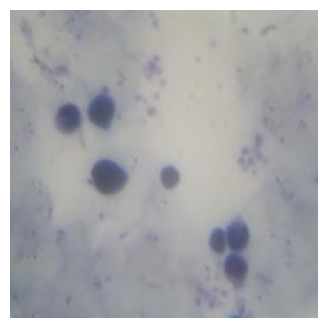

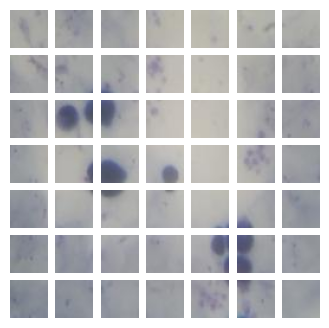

In [16]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer linearly transforms a patch by projecting it into a
vector of size `projection_dim`. It also adds a learnable position
embedding to the projected vector.

In [17]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model has multiple Transformer blocks.
The `MultiHeadAttention` layer is used for self-attention,
applied to the sequence of image patches. The encoded patches (skip connection)
and self-attention layer outputs are normalized and fed into a
multilayer perceptron (MLP).
The model outputs four dimensions representing
the bounding box coordinates of an object.

In [23]:
# Model definition
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    max_bboxes,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, num_patches, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Adjust the output layer to match the padded targets shape
    bounding_boxes = layers.Dense(max_bboxes * 4)(features)
    bounding_boxes = layers.Reshape((max_bboxes, 4))(bounding_boxes)

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_boxes)


## Run the experiment

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    max_bboxes,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/10
61/61 [==============================] - 154s 2s/step - loss: 0.9545 - val_loss: 0.8216
Epoch 2/10
23/61 [==========>...................] - ETA: 1:27 - loss: 0.8816

## Evaluate the model

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


mean_iou: 0.8641627948660334


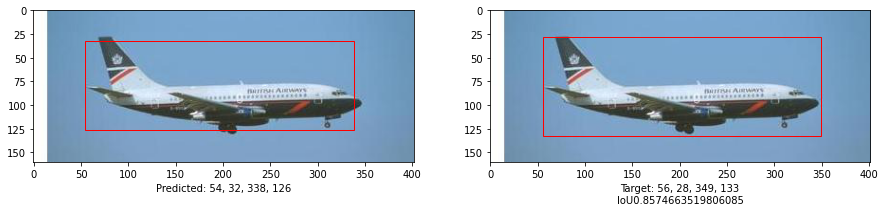

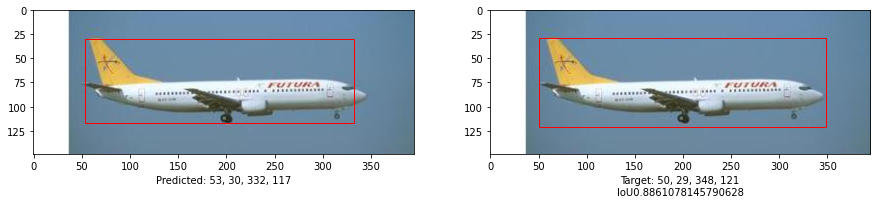

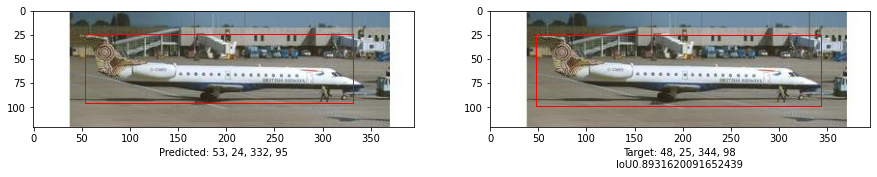

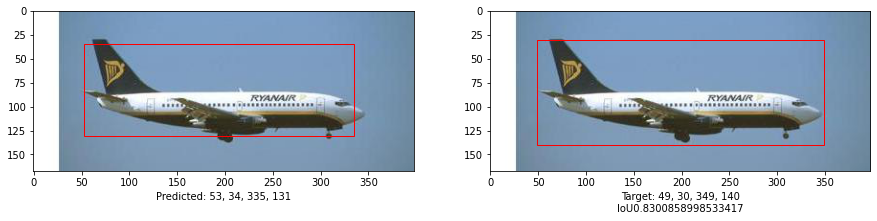

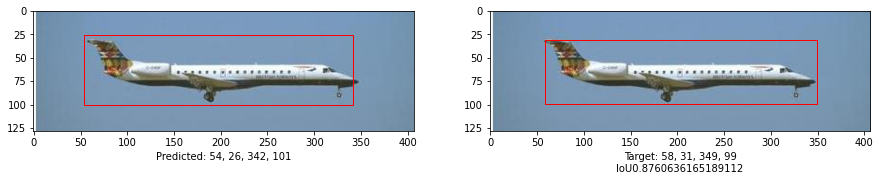

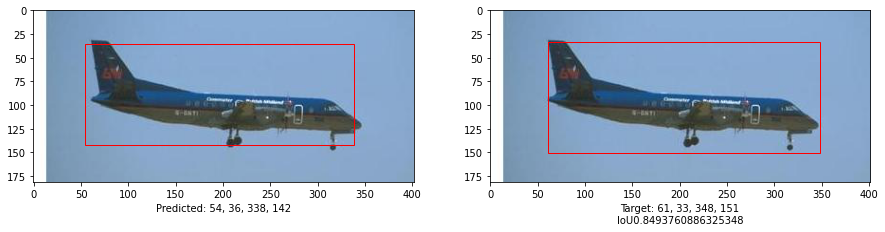

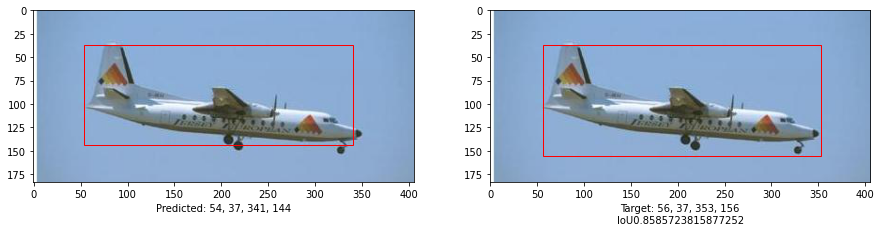

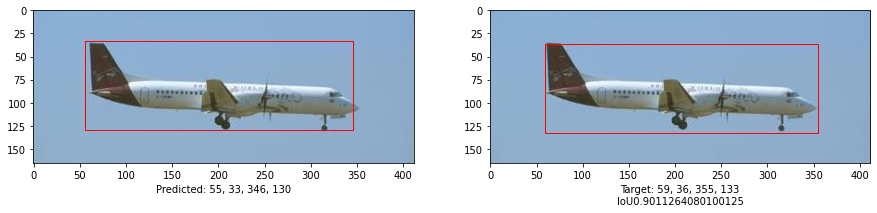

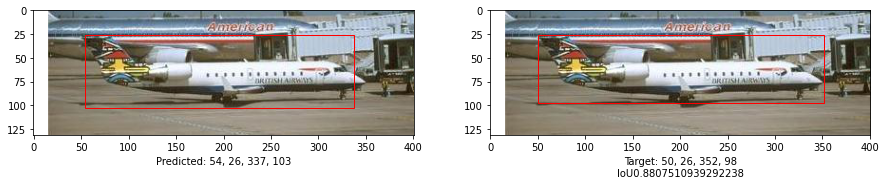

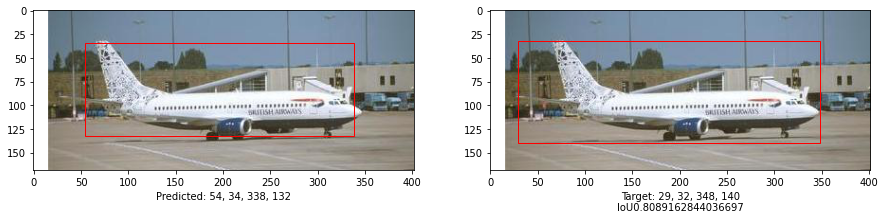

In [ ]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

This example demonstrates that a pure Transformer can be trained
to predict the bounding boxes of an object in a given image,
thus extending the use of Transformers to object detection tasks.
The model can be improved further by tuning hyper-parameters and pre-training.